In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import matplotlib.pyplot as plt
import glob
from copy import deepcopy
import sys
import os
np.set_printoptions(threshold=sys.maxsize)
sys.path.insert(1, '../pretrain-data-prep')
# https://github.com/smart-pix/pretrain-data-prep/tree/main
from dataset_utils import quantize_manual, add_noise

# Create training dataset from flat pT PixelAV datasets

In [2]:
# Global variables
threshold = 0.2
pixel_arrayX = 16 #21 #
pixel_arrayY = 16 #13 #
noise_threshold = 0
qm_charge_levels = [400, 1600, 2400]
qm_quant_values = [0,1,2,3]
y_local_bins = np.linspace(-8.1, 8.1, 13)
bin_number = 6
y_local_min, y_local_max = y_local_bins[bin_number], y_local_bins[bin_number+1]
sensor_geom = '50x12P5_100e-sigma'
train_dataset_name = 'dataset_3sNoise_16x16' # for train datasets
test_dataset_name = 'dataset_2sNoise_16x16' # for location of test (physical pT) datasets
# dataset_savedir = 'dataset_9s'
dataset_savedir = f'dataset_2sNoise_16x16_50x12P5_100e-sigma_{noise_threshold}NoiseThresh' # for save loc of final datasets
if not os.path.exists(dataset_savedir):
    os.makedirs(dataset_savedir)

In [3]:
def sumRow(X):
        X = np.where(X < noise_threshold, 0, X)
        sum1 = 0
        sumList = []
        for i in X:
            sum1 = np.sum(i,axis=0)
            sumList.append(sum1)
            b = np.array(sumList)
        return b

In [4]:
dirtrain = '/asic/projects/C/CMS_PIX_28/pixelAV_datasets/unshuffled_DO_NOT_DELETE/'+train_dataset_name+'/'+train_dataset_name+'_'+sensor_geom+'_parquets/unflipped/'
# /location/of/parquets/smartpixels/dataset_2s/dataset_2s_50x12P5_parquets/unflipped
dftrain = pd.read_parquet(dirtrain+'labels_d16401.parquet')
print(dftrain.head())
print(dftrain.tail())

      x-entry    y-entry  z-entry        n_x       n_y       n_z  \
0  269.683197   7.741928    100.0 -19.512375 -0.244761 -3.990751   
1  257.054901   9.590678    100.0  -6.506950 -0.142106 -1.403364   
2 -120.836288 -11.004836    100.0   6.012736  0.162117 -2.576504   
3  124.701225 -20.178518    100.0  -2.745467  0.036515 -0.732855   
4 -242.567215  10.704026    100.0  24.983065 -0.536664 -3.990835   

   number_eh_pairs  y-local        pt  cotAlpha   cotBeta  y-midplane  \
0          62765.0 -1.71100  3.998250  4.889399  0.061332    4.675325   
1          51626.0 -2.66939  1.410540  4.636680  0.101261    4.527629   
2          22837.0  2.08771  2.581600 -2.333680 -0.062921   -7.858771   
3          27033.0  2.19853  0.733765  3.746262 -0.049826  -17.687234   
4          50337.0 -4.16523 -4.026760 -6.260110  0.134474    3.980320   

   x-midplane  
0   25.213234  
1   25.220894  
2   -4.152285  
3  -62.611886  
4   70.438271  
          x-entry    y-entry  z-entry        n_x       n

240  files present in directory.
iter_0:  160470
iter_1:  2761
iter_2:  2845
iter_rem:  0


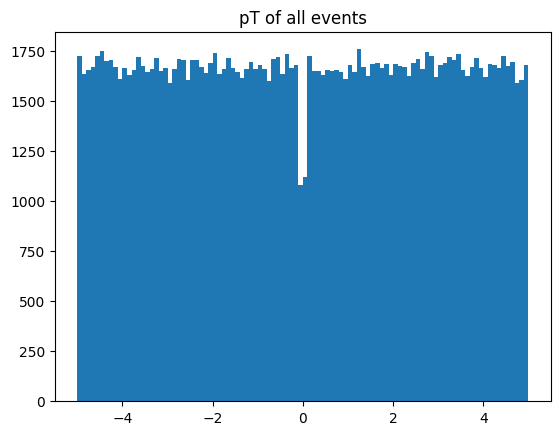

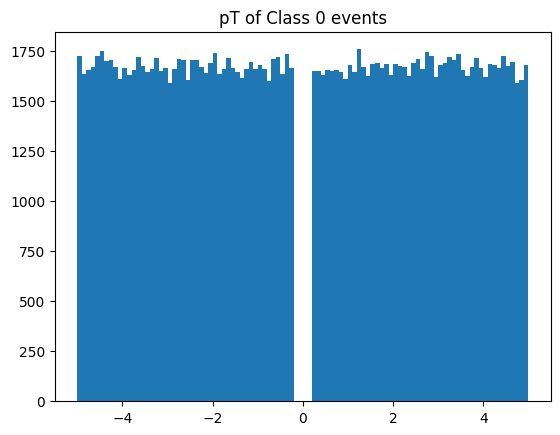

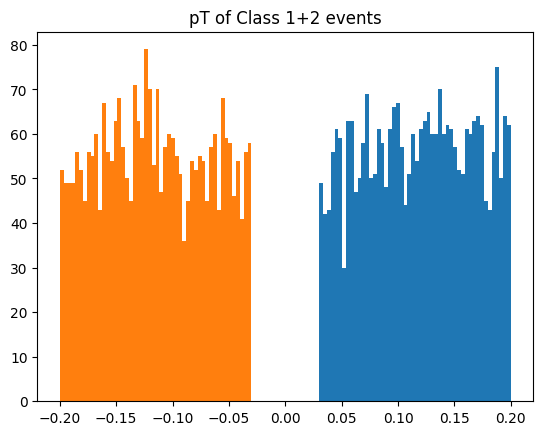

Number of events:  2000


In [5]:
trainlabels = []
trainrecons = []

iter=0
suffix = 16400
for filepath in glob.iglob(dirtrain+'labels*.parquet'):
    iter+=3
print(iter," files present in directory.")
for i in range(int(iter/3)):
        trainlabels.append(pd.read_parquet(dirtrain+'labels_d'+str(suffix+i+1)+'.parquet'))
        trainrecons.append(pd.read_parquet(dirtrain+'recon2D_d'+str(suffix+i+1)+'.parquet'))
trainlabels_csv = pd.concat(trainlabels, ignore_index=True)
trainrecons_csv = pd.concat(trainrecons, ignore_index=True)
# Retain events from only one y-local bin
filtered_indices = trainlabels_csv[(trainlabels_csv['y-local'] >= y_local_min) & (trainlabels_csv['y-local'] < y_local_max)].index
trainlabels_csv = trainlabels_csv.loc[filtered_indices].reset_index(drop=True)
trainrecons_csv = trainrecons_csv.loc[filtered_indices].reset_index(drop=True)

iter_0, iter_1, iter_2 = 0, 0, 0
iter_rem = 0
for iter, row in trainlabels_csv.iterrows():
    if(abs(row['pt'])>threshold):
        iter_0+=1
    elif(-1*threshold<=row['pt']<0):
        iter_1+=1
    elif(0<row['pt']<=threshold):
        iter_2+=1
    else:
        iter_rem+=1
print("iter_0: ",iter_0)
print("iter_1: ",iter_1)
print("iter_2: ",iter_2)
print("iter_rem: ",iter_rem)

plt.hist(trainlabels_csv['pt'], bins=100)
plt.title('pT of all events')
plt.show()

plt.hist(trainlabels_csv[abs(trainlabels_csv['pt'])>threshold]['pt'], bins=100)
plt.title('pT of Class 0 events')
plt.show()

plt.hist(trainlabels_csv[(0<=trainlabels_csv['pt'])&(trainlabels_csv['pt']<=threshold)]['pt'], bins=50)
plt.hist(trainlabels_csv[(-1*threshold<=trainlabels_csv['pt'])& (trainlabels_csv['pt']<0)]['pt'], bins=50)
plt.title('pT of Class 1+2 events')
plt.show()

number_of_events = (min(iter_1, iter_2)//1000)*1000
if(number_of_events*2>iter_0):
    number_of_events = (iter_0//1000)*1000/2
number_of_events = int(number_of_events)
print("Number of events: ",number_of_events)


## Quantize train data

In [6]:
trainrecons_csv.head()
trainrecons_csv_quantized = quantize_manual(trainrecons_csv, charge_levels=qm_charge_levels, quant_values=qm_quant_values, shuffled=True)
pd.options.display.max_columns = None
trainrecons_csv_quantized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0

## create y-profiles and final test data

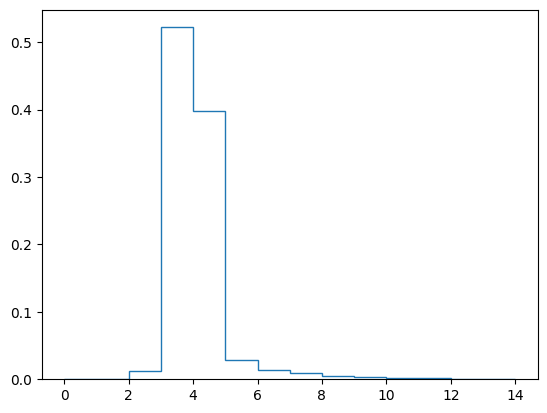

     0    1    2    3    4     5     6     7    8    9   10   11   12   13  \
0  0.0  0.0  0.0  0.0  3.0   6.0   3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  2.0   4.0   4.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0   0.0   9.0  12.0  9.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  1.0  6.0   5.0   2.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  3.0  16.0  14.0   5.0  0.0  0.0  0.0  0.0  0.0  0.0   

    14   15  cls        pt  
0  0.0  0.0    0  0.872947  
1  0.0  0.0    0  2.279300  
2  0.0  0.0    0  1.542350  
3  0.0  0.0    0 -2.993100  
4  0.0  0.0    0  3.103680  


In [7]:
trainlist1, trainlist2 = [], []
hist_temp=[]
for (index1, row1), (index2, row2) in zip(trainrecons_csv_quantized.iterrows(), trainlabels_csv.iterrows()):
    rowSum = 0.0
    X = row1.values
    X = np.reshape(X,(pixel_arrayY,pixel_arrayX))
    rowSum = sumRow(X)
    hist_temp.append(np.sum(rowSum>0))
    trainlist1.append(rowSum)
    cls = -1
    if(abs(row2['pt'])>threshold):
        cls=0
    elif(-1*threshold<=row2['pt']<0):
        cls=1
    elif(0<=row2['pt']<=threshold):
        cls=2
    trainlist2.append([cls, row2['pt']])
    # trainlist2.append([row2['y-local'], cls, row2['pt']]) # y-local is not passed in ASIC DNN as there is one DNN per y-local bin.

plt.hist(hist_temp, bins=14,  range=[0, 14], histtype='step', fill=False, density=True)
plt.show()
traindf_all = pd.concat([pd.DataFrame(trainlist1), pd.DataFrame(trainlist2 , columns=['cls', 'pt'])], axis=1)
# traindf_all = pd.concat([pd.DataFrame(trainlist1), pd.DataFrame(trainlist2 , columns=['y-local', 'cls', 'pt'])], axis=1)
print(traindf_all.head())

In [8]:
# totalsize = number_of_events
random_seed0 = 10#11
random_seed1 = 13#14
random_seed2 = 19#20

traindf_all = traindf_all.sample(frac=1, random_state=random_seed0).reset_index(drop=True)
# traindf_all.to_csv(dataset_savedir+'/'+'/FullTrainData_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
traindfcls0 = traindf_all.loc[traindf_all['cls']==0]
traindfcls1 = traindf_all.loc[traindf_all['cls']==1]
traindfcls2 = traindf_all.loc[traindf_all['cls']==2]
print(traindfcls0.shape)
print(traindfcls1.shape)
print(traindfcls2.shape)
print(traindfcls2.head())
# don't create balanced dataset as only 2000 events present in class 1/2 for 6th y-local bin
# traindfcls0 = traindfcls0.iloc[:2*totalsize]
# traindfcls1 = traindfcls1.iloc[:totalsize]
# traindfcls2 = traindfcls2.iloc[:totalsize]
print(traindfcls2.head())

traincls0 = traindfcls0.sample(frac = 1, random_state=random_seed1)
traincls1 = traindfcls1.sample(frac = 1, random_state=random_seed1)
traincls2 = traindfcls2.sample(frac = 1, random_state=random_seed1)
train = pd.concat([traincls0, traincls1, traincls2], axis=0)

train = train.sample(frac=1, random_state=random_seed2)

print(traincls0.shape)
print(traincls1.shape)
print(traincls2.shape)
print(train.shape)

trainlabel = train['cls']
trainpt = train['pt']
train = train.drop(['cls', 'pt'], axis=1)

print(train.shape)
print(trainlabel.shape)
print(trainpt.shape)

train.to_csv(dataset_savedir+'/FullPrecisionInputTrainSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
trainlabel.to_csv(dataset_savedir+'/TrainSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
trainpt.to_csv(dataset_savedir+'/TrainSetPt_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)

(160470, 18)
(2761, 18)
(2845, 18)
       0    1    2     3     4     5    6     7     8    9   10   11   12  \
16   0.0  0.0  6.0  16.0  17.0  13.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   
298  0.0  0.0  0.0   1.0   5.0   5.0  6.0   8.0   6.0  4.0  0.0  0.0  0.0   
351  0.0  0.0  0.0   0.0   5.0   8.0  7.0  10.0   6.0  0.0  0.0  0.0  0.0   
526  0.0  0.0  0.0   0.0   0.0   0.0  8.0  11.0  10.0  6.0  0.0  0.0  0.0   
569  0.0  0.0  0.0   0.0   0.0   2.0  4.0   9.0  10.0  4.0  4.0  4.0  0.0   

      13   14   15  cls        pt  
16   0.0  0.0  0.0    2  0.106225  
298  0.0  0.0  0.0    2  0.046085  
351  0.0  0.0  0.0    2  0.082972  
526  0.0  0.0  0.0    2  0.196652  
569  0.0  0.0  0.0    2  0.144967  
       0    1    2     3     4     5    6     7     8    9   10   11   12  \
16   0.0  0.0  6.0  16.0  17.0  13.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0   
298  0.0  0.0  0.0   1.0   5.0   5.0  6.0   8.0   6.0  4.0  0.0  0.0  0.0   
351  0.0  0.0  0.0   0.0   5.0   8.0  7.0  10.0   6.0  

# Create test datasets from physical PixelAV dataset

In [9]:
dirtest = '/asic/projects/C/CMS_PIX_28/pixelAV_datasets/unshuffled_DO_NOT_DELETE/'+test_dataset_name+'/'+test_dataset_name+'_'+sensor_geom+'_parquets/unflipped/'
# /location/of/parquets/smartpixels/dataset_2s/dataset_2s_50x12P5_parquets/unflipped
dftest = pd.read_parquet(dirtest+'labels_d16401.parquet')
print(dftest.head())
print(dftest.tail())

      x-entry    y-entry  z-entry        n_x       n_y       n_z  \
0  269.719208   7.863062    100.0 -12.481166 -0.162723 -2.552323   
1  133.550354   0.556607    100.0  -7.872302 -0.168339 -1.698176   
2 -199.561096 -18.579504    100.0   4.568447  0.119067 -1.957884   
3  254.472351  -8.015524    100.0  -5.973920  0.099579 -1.593390   
4 -327.941132  22.600853    100.0  15.991411 -0.337354 -2.555322   

   number_eh_pairs  y-local      pt  cotAlpha   cotBeta  y-midplane  \
0          66080.0 -1.71100  2.5575  4.890120  0.063755    4.675319   
1          44637.0 -2.66939  1.7065  4.635740  0.099129   -4.399858   
2          17669.0  2.08771  1.9615 -2.333359 -0.060814  -15.538798   
3          34167.0  2.19853  1.5965  3.749189 -0.062495   -4.890771   
4          47673.0 -4.16523 -2.5775 -6.258081  0.132020   15.999845   

   x-midplane  
0   25.213203  
1  -98.236634  
2  -82.893127  
3   67.012909  
4  -15.037103  
          x-entry    y-entry  z-entry        n_x       n_y       n_z

246  files present in directory.
iter_0:  131937
iter_1:  18924
iter_2:  18753
iter_rem:  0


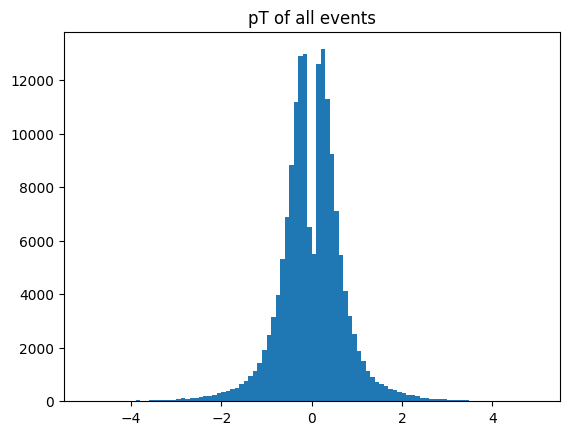

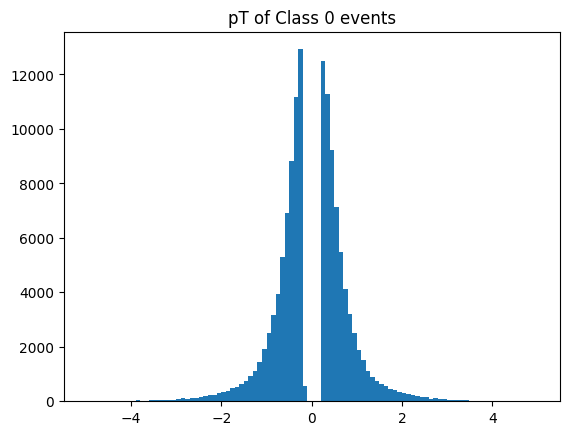

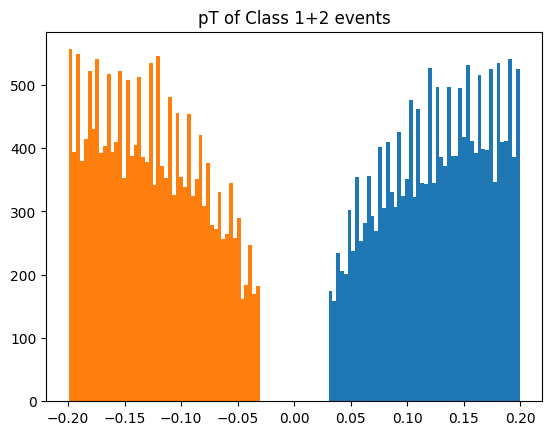

Number of events:  18000


In [10]:
testlabels = []
testrecons = []

iter=0
suffix = 16400
for filepath in glob.iglob(dirtest+'labels*.parquet'):
    iter+=3
print(iter," files present in directory.")
for i in range(int(iter/3)):
        testlabels.append(pd.read_parquet(dirtest+'labels_d'+str(suffix+i+1)+'.parquet'))
        testrecons.append(pd.read_parquet(dirtest+'recon2D_d'+str(suffix+i+1)+'.parquet'))
testlabels_csv = pd.concat(testlabels, ignore_index=True)
testrecons_csv = pd.concat(testrecons, ignore_index=True)

# Retain events from only one y-local bin
filtered_indices = testlabels_csv[(testlabels_csv['y-local'] >= y_local_min) & (testlabels_csv['y-local'] < y_local_max)].index
testlabels_csv = testlabels_csv.loc[filtered_indices].reset_index(drop=True)
testrecons_csv = testrecons_csv.loc[filtered_indices].reset_index(drop=True)

iter_0, iter_1, iter_2 = 0, 0, 0
iter_rem = 0
for iter, row in testlabels_csv.iterrows():
    if(abs(row['pt'])>threshold):
        iter_0+=1
    elif(-1*threshold<=row['pt']<0):
        iter_1+=1
    elif(0<row['pt']<=threshold):
        iter_2+=1
    else:
        iter_rem+=1
print("iter_0: ",iter_0)
print("iter_1: ",iter_1)
print("iter_2: ",iter_2)
print("iter_rem: ",iter_rem)

plt.hist(testlabels_csv['pt'], bins=100)
plt.title('pT of all events')
plt.show()

plt.hist(testlabels_csv[abs(testlabels_csv['pt'])>threshold]['pt'], bins=100)
plt.title('pT of Class 0 events')
plt.show()

plt.hist(testlabels_csv[(0<=testlabels_csv['pt'])&(testlabels_csv['pt']<=threshold)]['pt'], bins=50)
plt.hist(testlabels_csv[(-1*threshold<=testlabels_csv['pt'])& (testlabels_csv['pt']<0)]['pt'], bins=50)
plt.title('pT of Class 1+2 events')
plt.show()

number_of_events = (min(iter_1, iter_2)//1000)*1000
if(number_of_events*2>iter_0):
    number_of_events = (iter_0//1000)*1000/2
number_of_events = int(number_of_events)
print("Number of events: ",number_of_events)


## Quantize test data

In [11]:
testrecons_csv.head()
testrecons_csv_quantized = quantize_manual(testrecons_csv, charge_levels=qm_charge_levels, quant_values=qm_quant_values, shuffled=True)
pd.options.display.max_columns = None
testrecons_csv_quantized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0

In [12]:
testlist1, testlist2 = [], []

for (index1, row1), (index2, row2) in zip(testrecons_csv_quantized.iterrows(), testlabels_csv.iterrows()):
    rowSum = 0.0
    X = row1.values
    X = np.reshape(X,(pixel_arrayY,pixel_arrayX))
    rowSum = sumRow(X)
    testlist1.append(rowSum)
    cls = -1
    if(abs(row2['pt'])>threshold):
        cls=0
    elif(-1*threshold<=row2['pt']<0):
        cls=1
    elif(0<=row2['pt']<=threshold):
        cls=2
    testlist2.append([cls, row2['pt']])
testdf_all = pd.concat([pd.DataFrame(testlist1), pd.DataFrame(testlist2 , columns=['cls', 'pt'])], axis=1)
print(testdf_all.head())

     0    1    2     3     4    5    6     7     8    9   10   11   12   13  \
0  0.0  0.0  0.0   0.0   4.0  4.0  1.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0   0.0   0.0  3.0  4.0   3.0   0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  1.0  10.0  12.0  7.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0   0.0   0.0  3.0  5.0   6.0   0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0   0.0   0.0  0.0  9.0  16.0  14.0  0.0  0.0  0.0  0.0  0.0   

    14   15  cls      pt  
0  0.0  0.0    0  1.6175  
1  0.0  0.0    0  1.8845  
2  0.0  0.0    0  1.7305  
3  0.0  0.0    0 -2.0845  
4  0.0  0.0    0  2.1215  


In [13]:
# totalsize = number_of_events#227000
random_seed0 = 10#11
random_seed1 = 13#14
random_seed2 = 19#20

testdf_all = testdf_all.sample(frac=1, random_state=random_seed0).reset_index(drop=True)
testdf_all.to_csv(dataset_savedir+'/'+'/FullTestData_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
# testdfcls0 = testdf_all.loc[testdf_all['cls']==0]
# testdfcls1 = testdf_all.loc[testdf_all['cls']==1]
# testdfcls2 = testdf_all.loc[testdf_all['cls']==2]
# print(testdfcls0.shape)
# print(testdfcls1.shape)
# print(testdfcls2.shape)
# print(testdfcls2.head())
# testdfcls0 = testdfcls0.iloc[:2*totalsize]
# testdfcls1 = testdfcls1.iloc[:totalsize]
# testdfcls2 = testdfcls2.iloc[:totalsize]
# print(testdfcls2.head())

# testcls0 = testdfcls0.sample(frac = 1, random_state=random_seed1)
# testcls1 = testdfcls1.sample(frac = 1, random_state=random_seed1)
# testcls2 = testdfcls2.sample(frac = 1, random_state=random_seed1)
# test = pd.concat([testcls0, testcls1, testcls2], axis=0)

# test = test.sample(frac=1, random_state=random_seed2)
test=testdf_all
# print(testcls0.shape)
# print(testcls1.shape)
# print(testcls2.shape)
print(test.shape)

testlabel = test['cls']
testpt = test['pt']
test = test.drop(['cls', 'pt'], axis=1)

print(test.shape)
print(testlabel.shape)
print(testpt.shape)

test.to_csv(dataset_savedir+'/FullPrecisionInputTestSet_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
testlabel.to_csv(dataset_savedir+'/TestSetLabel_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)
testpt.to_csv(dataset_savedir+'/TestSetPt_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv', index=False)

(169614, 18)
(169614, 16)
(169614,)
(169614,)
